# Bird Image Classification!

**Author:** Sarang Galada<br>
**Email ID:** sarang[dot]galada[at]gmail[dot]com<br>
**Date created:** 13/12/2024<br><br>
**Description:** A Computer Vision pipeline for classifying raw bird images with high accuracy

*   *Problem*: `Image Classification`
*   *Dataset*: `Bird images of varying sizes`
*   *Models*: `ConvNeXt`, `Swin Transformer`, `ViT`, `EfficientNet`
*   *Key libraries used*: `PyTorch`, `OpenCV`

In [ ]:
# Import Libraries
import os
from glob import glob
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# Define Macros

BATCH_SIZE = 16 # 32 16 8
EPOCHS = 10
LR = 1e-4
MODEL = 'ConvNeXt' # 'ViT' 'Swin_t' 'ConvNeXt' 'EfficientNet' 'ResNet'

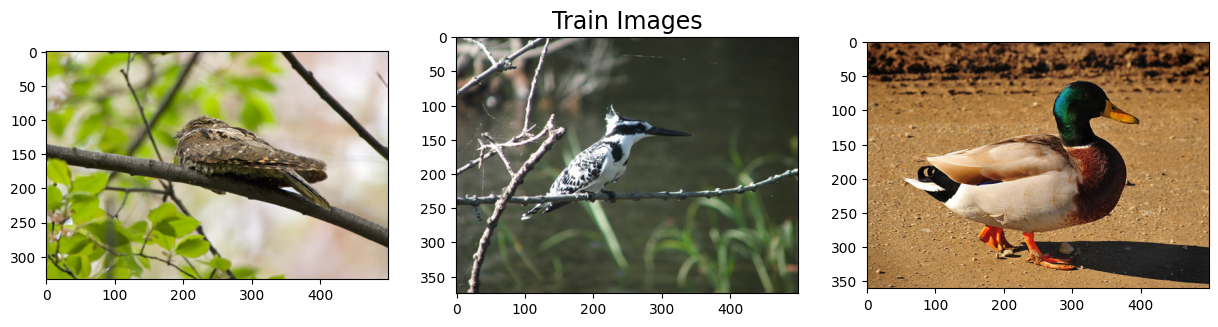

In [ ]:
# Plot some random train and test images

train_images = glob('images/train/*.jpg')[0:3]
test_images = glob('images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

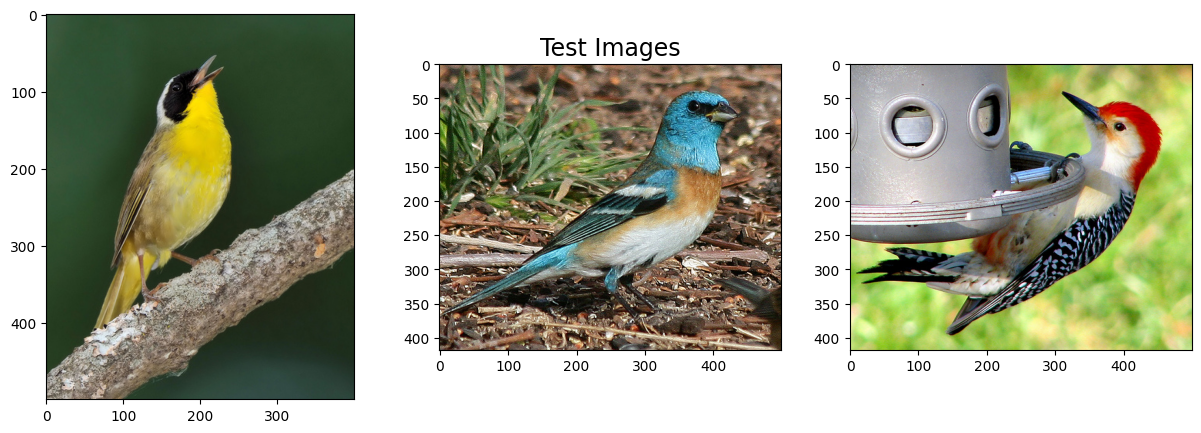

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

# ****Data preprocessing****

In [ ]:
# Custom Dataset for storing bird cropped images and labels
class BirdDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
#         bbox = list(map(int, self.data.iloc[idx]['bbox'].split()))  # Parse bbox
        bbox = list(map(lambda x: int(float(x)), self.data.iloc[idx]['bbox'].split()))
        class_label = self.data['class'][idx] if 'class' in self.data.columns else -1  # Handle test data

        # Load image
        img = cv2.imread(img_path)
#         print(f"{img_path}, {img.shape}")
#         print(bbox)
        x, y, w, h = bbox
        img = img[y:y+h, x:x+w]  # Crop image
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if self.transform:
            img = self.transform(img)

        return img, class_label

In [ ]:
# Dataset transforms - separate for train and test
# From my experiments, augmentations tend to hinder max performance, hence commented out

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(),
#     transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Loading train data and creating stratified validation split for training and eval purposes
train_data = pd.read_csv('train.csv')
train_df, val_df = train_test_split(train_data, test_size=0.1, stratify=train_data['class'], random_state=42)

# save the datasets
train_df.to_csv('stratified_train.csv', index=False)
val_df.to_csv('validation.csv', index=False)

# Datasets and dataloaders
train_dataset = BirdDataset(csv_path='stratified_train.csv', transform=train_transform)
val_dataset = BirdDataset(csv_path='validation.csv', transform=test_transform)
test_dataset = BirdDataset(csv_path='test.csv', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Model init and training**

In [ ]:
# Model Setup

# Based on literature review, narrowed down on 4-6 models for transfer learning experiments
# (Set macro 'MODELS') Options: ConvNeXt, Swin_t, ViT, EfficientNet, ResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_data['class'].unique())

if MODEL == 'swin_t':
    model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)  # Pretrained model
    model.head = nn.Linear(model.head.in_features, num_classes)  # Adjust output layer

elif MODEL == 'ConvNeXt':
    model = models.convnext_tiny(weights="ConvNeXt_Tiny_Weights.IMAGENET1K_V1")  # Use pretrained weights
    model.classifier[2] = torch.nn.Linear(model.classifier[2].in_features, num_classes)  # Modify the classifier head

elif MODEL == 'ViT':
    model = models.vit_b_16(weights="ViT_B_16_Weights.IMAGENET1K_V1")  # Use pretrained weights
    model.heads.head = torch.nn.Linear(model.heads.head.in_features, num_classes)  # Modify the classifier head

elif MODEL == 'EfficientNet':
    model = models.efficientnet_b7(weights="EfficientNet_B7_Weights.IMAGENET1K_V1")  # Use pretrained weights
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)  # Modify the classifier head

# Save the original pretrained model to avoid downloading ever time
torch.save(model.state_dict(), f"{MODEL}_pretrained.pth")
model = model.to(device) # move model to training device

In [ ]:
# Loss criterion, Optimizer and Scheduler for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
# Training Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_acc}")
        scheduler.step()

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=EPOCHS)

Epoch 1/10, Train Loss: 3.7478295783319417
Validation Loss: 1.8018953800201416, Validation Accuracy: 0.7033333333333334
Epoch 2/10, Train Loss: 1.095010753125834
Validation Loss: 0.8293186324207407, Validation Accuracy: 0.835
Epoch 3/10, Train Loss: 0.3818188437299263
Validation Loss: 0.6572984166835484, Validation Accuracy: 0.8416666666666667
Epoch 4/10, Train Loss: 0.15782019620507778
Validation Loss: 0.587629578027286, Validation Accuracy: 0.8516666666666667
Epoch 5/10, Train Loss: 0.08563792814098342
Validation Loss: 0.5704784052152383, Validation Accuracy: 0.8616666666666667
Epoch 6/10, Train Loss: 0.05708395462681556
Validation Loss: 0.5554500130054197, Validation Accuracy: 0.8666666666666667
Epoch 7/10, Train Loss: 0.04267659034723273
Validation Loss: 0.5637503183986011, Validation Accuracy: 0.86
Epoch 8/10, Train Loss: 0.033998105797597024
Validation Loss: 0.5482425421084228, Validation Accuracy: 0.8583333333333333
Epoch 9/10, Train Loss: 0.03081996516826061
Validation Loss: 0.

In [ ]:
# Save the trained model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'num_classes': len(train_data['class'].unique())
}

folder = f"runs/{MODEL}_e{EPOCHS}_b{BATCH_SIZE}_85percent"
if not os.path.exists(folder):
    os.makedirs(folder)

torch.save(checkpoint, f"{folder}/{MODEL}_model.pth")

# **Inference**

In [ ]:
from tqdm import tqdm

def save_test_predictions(model, test_csv_path, output_csv_path="predictions.csv"):
    test_data = pd.read_csv(test_csv_path)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust for the model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
    ])

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    predictions = []

    with torch.no_grad():
        for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing Test Set"):
            # Extract image path and bbox
            img_path = row['path']
            bbox = list(map(lambda x: int(float(x)), row['bbox'].split()))

            # load image, and crop based on bbox
            img = cv2.imread(img_path)
            x, y, w, h = bbox
            img = img[y:y+h, x:x+w]  # Crop image
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            # Apply transforms
            img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

            # Infer model on test set
            outputs = model(img)
            probabilities = torch.softmax(outputs, dim=1)
            confidence_score, predicted_label = torch.max(probabilities, dim=1)

            # Collect predictions
            predictions.append({
                "path": img_path,
                "predicted_label": int(predicted_label.cpu().item()),
                "confidence_score": float(confidence_score.cpu().item())
            })

    # Save predictions to CSV
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

save_test_predictions(
    model,
    test_csv_path="test.csv",
    output_csv_path="predictions.csv"
)

Processing Test Set: 100% 5794/5794 [01:36<00:00, 59.81it/s] 

Predictions saved to predictions.csv


/tmp/ipykernel_10907/2703378631.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Clipping input data to the valid range for imshow wi

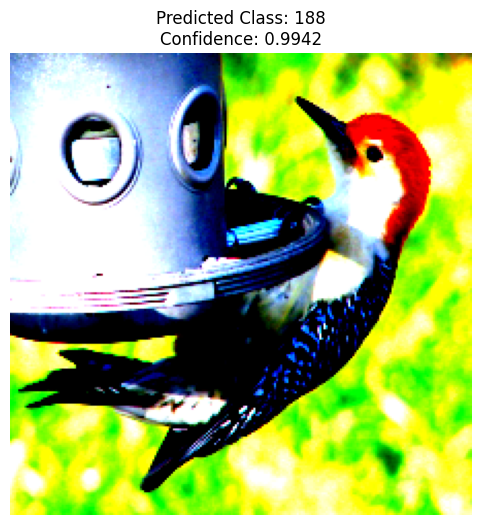

In [ ]:
# Plot a sample result

def plot_image_with_prediction(model_path, test_path, idx, device='cuda'):
    # Load the fine-tuned model from the given path
    checkpoint = torch.load(model_path)
    model = models.swin_t(weights=None)  # Initialize the model without pretrained weights
    model.head = torch.nn.Linear(model.head.in_features, checkpoint['num_classes'])  # Ensure the custom head is added
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    files = [f for f in os.listdir(test_path)]
    img_path = os.path.join(test_path, files[idx])
    image = Image.open(img_path).convert("RGB")

    # Transform the image (same as during training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to fit the model's input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])
    input_image = transform(image).unsqueeze(0).to(device)


    # Set model to evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
#         output = model(input_image)
        output = model(input_image)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    predicted_class = predicted_class.item()
    confidence_score = confidence.item()

    # Display the image with the predicted class and confidence
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(input_image.squeeze().cpu().permute(1, 2, 0))
    ax.set_title(f"Predicted Class: {predicted_class}\nConfidence: {confidence_score:.4f}")
    plt.axis('off')
    plt.show()

model_path = "runs/model.pth"
test_path = "images/test"
plot_image_with_prediction(model_path, test_path, idx=2, device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Accurary - overall and class-wise

print('Accuracy: ')
print(send_results_for_evaluation('First Last', 'predictions.csv', ''))

{'overall_accuracy (%)': 86.93476, 'max_accuracy_class': 46, 'max_accuracy (%)': 100.0, 'min_accuracy_class': 58, 'min_accuracy (%)': 33.33333}
